<a href="https://colab.research.google.com/github/Firas2001-cyber/Projet-Python/blob/main/Retour%20%C3%A0%20la%20moyenne%20EURUSD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [ ]:
#Préparation des données
ticker = "EURUSD=X"
data = yf.download(ticker, start="2010-01-01", end="2025-11-30")
df = data['Close'].copy()
df.columns = ['Price']

/tmp/ipython-input-3077520980.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2010-01-01", end="2025-11-30")
[*********************100%***********************]  1 of 1 completed


In [ ]:
df['Delta_X'] = df['Price'].diff()
df['Lag_X'] = df['Price'].shift(1)
df.dropna(inplace=True)
Y_full = df['Delta_X']
X_full = sm.add_constant(df['Lag_X'])
full_model = sm.OLS(Y_full, X_full).fit()
alpha_full = full_model.params.iloc[0]
beta_full = full_model.params.iloc[1]
t_stat_beta = full_model.tvalues.iloc[1] # This is the t-statistic for beta

print(f"Full Sample Results:")
print(f"Alpha: {alpha_full:.6f}, Beta: {beta_full:.6f}")
print(f"T-statistic for Beta: {t_stat_beta:.4f}")

# Comparer avec la valeur critique (eg -1.0)
if alpha_full > 0 and beta_full < 0 and t_stat_beta < -1.0:
    print("Result: Full sample exhibits statistically significant mean reversion.")
else:
    print("Result: Full sample does NOT exhibit significant mean reversion.")

Full Sample Results:
Alpha: 0.002631, Beta: -0.002275
T-statistic for Beta: -2.5396
Result: Full sample exhibits statistically significant mean reversion.


In [ ]:
#La stratégie de trading
window = 80
critical_value = -1
df['Position'] = 0
for i in range (window, len(df)):
  window_data = df.iloc[i-window:i]
  Y = window_data['Delta_X']
  X = sm.add_constant(window_data['Lag_X'])
  model = sm.OLS(Y, X).fit()
  alpha_hat = model.params.iloc[0]
  beta_hat = model.params.iloc[1]
  t_beta = model.tvalues.iloc[1]
#le cours actuel
  X_t = df.iloc[i]['Price']

#Introduire lescritères à prendre en compte
  if alpha_hat > 0 and beta_hat < 0 and t_beta < critical_value:
    expected_change = alpha_hat + beta_hat * X_t

    if expected_change > 0:
      df.iloc[i, df.columns.get_loc('Position')] = 1  # Achat EUR
    elif expected_change < 0:
      df.iloc[i, df.columns.get_loc('Position')] = -1 # Achat USD
    else:
      df.iloc[i, df.columns.get_loc('Position')] = 0

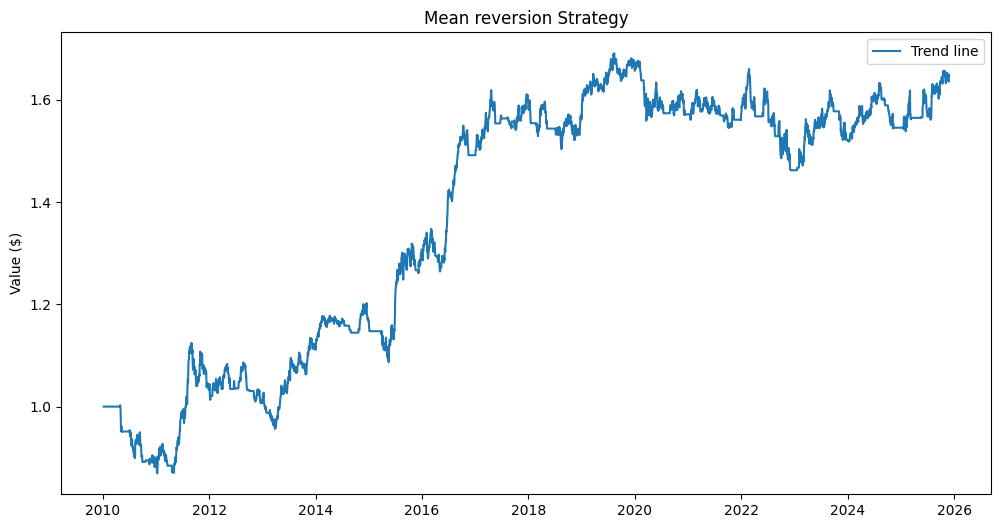

In [ ]:
#Calculer la perf et visualiser
df['Daily_Return'] = df['Price'].pct_change()
df['Strategy_Returns'] = df['Position'].shift(1) * df['Daily_Return']
df['Cumulative_Performance'] = (1 + df['Strategy_Returns'].fillna(0)).cumprod()

plt.figure(figsize=(12, 6))
plt.plot(df['Cumulative_Performance'], label='Trend line')
plt.title('Mean reversion Strategy')
plt.ylabel('Value ($)')
plt.legend()
plt.show()
